In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

# **Load Dataset**

In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We see our 81 dimensions of our dataset by printing 1st 5 entries using following code:

In [4]:
dataset_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* There are 79 features columns. Using this feature our model has to predict the house sale price indicated by the label column name SalePrice.

We drop Id column as it's not necessary for training mode 

In [5]:
dataset_df=dataset_df.drop('Id',axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can inspect the types of feature columns using following code:

In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# **Dataset Preprocessing**
* Check missing value
* if missing value exist:
* * 1. drop that columns
* * 2. or fill missing value with their mean value
* * 3. for categorical missing value fill with below's column value

In [7]:
#Check missing value
dataset_df_missing=dataset_df.isnull().sum()
dataset_df_missing[40:]

CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           1453
Fence            1179
MiscFeature      1406
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
dtype: int64

In [8]:
#LotFrontage column's missing value replace with mean value
dataset_df['LotFrontage']=dataset_df['LotFrontage'].fillna(dataset_df['LotFrontage'].mean())

In [9]:
# for Alley  column's so much values are missing , so drop Alley column
dataset_df.drop('Alley',axis=1,inplace=True)
dataset_df.drop('PoolQC',axis=1,inplace=True)
dataset_df.drop('Fence',axis=1,inplace=True)
dataset_df.drop('MiscFeature',axis=1,inplace=True)

In [10]:
dataset_df['MasVnrType']=dataset_df['MasVnrType'].fillna(dataset_df['MasVnrType'].mode()[0])


In [11]:
dataset_df['BsmtQual']=dataset_df['BsmtQual'].fillna(dataset_df['BsmtQual'].mode()[0])
dataset_df['BsmtCond']=dataset_df['BsmtCond'].fillna(dataset_df['BsmtCond'].mode()[0])
dataset_df['BsmtExposure']=dataset_df['BsmtExposure'].fillna(dataset_df['BsmtExposure'].mode()[0])
dataset_df['BsmtFinType1']=dataset_df['BsmtFinType1'].fillna(dataset_df['BsmtFinType1'].mode()[0])
dataset_df['BsmtFinType2']=dataset_df['BsmtFinType2'].fillna(dataset_df['BsmtFinType2'].mode()[0])
dataset_df['Electrical']=dataset_df['Electrical'].fillna(dataset_df['Electrical'].mode()[0])
dataset_df['FireplaceQu']=dataset_df['FireplaceQu'].fillna(dataset_df['FireplaceQu'].mode()[0])
dataset_df['GarageType']=dataset_df['GarageType'].fillna(dataset_df['GarageType'].mode()[0])
dataset_df['GarageFinish']=dataset_df['GarageFinish'].fillna(dataset_df['GarageFinish'].mode()[0])
dataset_df['GarageQual']=dataset_df['GarageQual'].fillna(dataset_df['GarageQual'].mode()[0])
dataset_df['GarageCond']=dataset_df['GarageCond'].fillna(dataset_df['GarageCond'].mode()[0])
#GarageYrBlt -->float type data
dataset_df['GarageYrBlt']=dataset_df['GarageYrBlt'].fillna(dataset_df['GarageYrBlt'].mean())

In [12]:
dataset_df_missing=dataset_df.isnull().sum()
dataset_df_missing[50:]

KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
dtype: int64

In [13]:
dataset_df.head(20)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.000000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.000000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.000000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.000000,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.000000,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,70.049958,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.000000,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.000000,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2008,WD,Normal,118000


# # Handle categorical features

In [14]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for col_name in dataset_df.columns:
    if dataset_df[col_name].dtypes=='object':
        dataset_df[col_name]=labelencoder.fit_transform(dataset_df[col_name])

In [15]:
X = dataset_df.drop(['SalePrice'], axis=1)
y = dataset_df['SalePrice'] 

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, random_state=42)

# **Machine Learning Model**

XGBRegressor

In [17]:
xgb_param = {
            'n_estimators': 1000,
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_child_samples':5,
            'scoring' : 'neg_mean_squared_error',
            'subsample': 0.8
            }

model_xgbr = XGBRegressor(**xgb_param)
model_xgbr.fit(X_train, y_train)
pred_xgbr = model_xgbr.predict(X_valid)
mse_xgbr = mean_squared_error(y_valid, pred_xgbr)
xgbr_rmse = np.sqrt(mse_xgbr)
print("xgbr_rmse:", xgbr_rmse)

xgbr_rmse: 25546.14891088714


In [18]:
lgb_param = {'random_state' : 42,
          'n_estimators': 100,
          'learning_rate': 0.1,
          'colsample_bytree': 0.7,
          }
model_lgbr = LGBMRegressor(**lgb_param)
model_lgbr.fit(X_train, y_train)
pred_lgbr = model_lgbr.predict(X_valid)
mse_lgbr = mean_squared_error(y_valid, pred_lgbr)
lgbr_rmse = np.sqrt(mse_lgbr)
print("medae_lgbmr:", lgbr_rmse)

medae_lgbmr: 28884.308483119723


In [19]:
cat_param = {
            'depth': 7,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'subsample':0.7,
            'colsample_bylevel':0.5,
            'min_data_in_leaf':10,
            'random_state': 42}
model_catboost = CatBoostRegressor(**cat_param)
model_catboost.fit(X_train, y_train)
pred_catboost = model_catboost.predict(X_valid)
mse_catboost = mean_squared_error(y_valid, pred_catboost)
catboost_rmse = np.sqrt(mse_catboost)
print("catboost_rmse:", catboost_rmse)


0:	learn: 71693.0175497	total: 57.3ms	remaining: 57.3s
1:	learn: 66748.8435871	total: 61.1ms	remaining: 30.5s
2:	learn: 61962.7736157	total: 64.4ms	remaining: 21.4s
3:	learn: 57630.9691358	total: 67.9ms	remaining: 16.9s
4:	learn: 53971.0227212	total: 71.1ms	remaining: 14.2s
5:	learn: 50624.4584477	total: 74.4ms	remaining: 12.3s
6:	learn: 47531.6878831	total: 77.4ms	remaining: 11s
7:	learn: 44675.9955412	total: 80.3ms	remaining: 9.96s
8:	learn: 42244.5059755	total: 83ms	remaining: 9.14s
9:	learn: 39975.8635781	total: 86ms	remaining: 8.51s
10:	learn: 37866.0402491	total: 88.9ms	remaining: 7.99s
11:	learn: 35982.5648729	total: 91.9ms	remaining: 7.57s
12:	learn: 34147.5321661	total: 96.3ms	remaining: 7.31s
13:	learn: 32481.7565803	total: 99.4ms	remaining: 7s
14:	learn: 30951.0552833	total: 102ms	remaining: 6.71s
15:	learn: 29676.7320509	total: 105ms	remaining: 6.46s
16:	learn: 28371.0958934	total: 108ms	remaining: 6.23s
17:	learn: 27298.1961066	total: 111ms	remaining: 6.04s
18:	learn: 2624

In [20]:

print("rmse_xgbr:", xgbr_rmse)
print("rmse_lgbr:", lgbr_rmse)
print("rmse_catboost:", catboost_rmse)

rmse_xgbr: 25546.14891088714
rmse_lgbr: 28884.308483119723
rmse_catboost: 27249.928337870602


In [21]:
compare = {'model':['XGBRegressor','LGBMRegressor','catboostRegressor'],
           'rmse':[xgbr_rmse,lgbr_rmse,catboost_rmse]}
compare_df = pd.DataFrame(compare)
compare_df

,model,rmse
0,XGBRegressor,25546.148911
1,LGBMRegressor,28884.308483
2,catboostRegressor,27249.928338


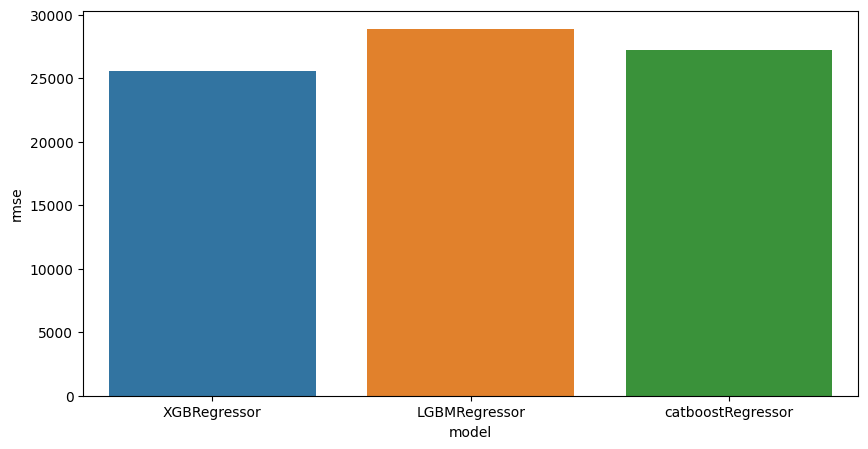

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x='model',y='rmse',data=compare_df)
plt.show()

# **preprocess Test Data**

In [23]:
test_data = pd.read_csv(r"/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [24]:
# for Alleyall  column's so much values are missing , so drop Alley column
test_data.drop('Alley',axis=1,inplace=True)
test_data.drop('PoolQC',axis=1,inplace=True)
test_data.drop('Fence',axis=1,inplace=True)
test_data.drop('MiscFeature',axis=1,inplace=True)

In [25]:
test_data['LotFrontage']=test_data['LotFrontage'].fillna(test_data['LotFrontage'].mean())
test_data['MasVnrType']=test_data['MasVnrType'].fillna(test_data['MasVnrType'].mode()[0])


In [26]:
test_data['BsmtQual']=test_data['BsmtQual'].fillna(test_data['BsmtQual'].mode()[0])
test_data['BsmtCond']=test_data['BsmtCond'].fillna(test_data['BsmtCond'].mode()[0])
test_data['BsmtExposure']=test_data['BsmtExposure'].fillna(test_data['BsmtExposure'].mode()[0])
test_data['BsmtFinType1']=test_data['BsmtFinType1'].fillna(test_data['BsmtFinType1'].mode()[0])
test_data['BsmtFinType2']=test_data['BsmtFinType2'].fillna(test_data['BsmtFinType2'].mode()[0])
test_data['Electrical']=test_data['Electrical'].fillna(test_data['Electrical'].mode()[0])
test_data['FireplaceQu']=test_data['FireplaceQu'].fillna(test_data['FireplaceQu'].mode()[0])
test_data['GarageType']=test_data['GarageType'].fillna(test_data['GarageType'].mode()[0])
test_data['GarageFinish']=test_data['GarageFinish'].fillna(test_data['GarageFinish'].mode()[0])
test_data['GarageQual']=test_data['GarageQual'].fillna(test_data['GarageQual'].mode()[0])
test_data['GarageCond']=test_data['GarageCond'].fillna(test_data['GarageCond'].mode()[0])
#GarageYrBlt -->float type data
test_data['GarageYrBlt']=test_data['GarageYrBlt'].fillna(test_data['GarageYrBlt'].mean())

In [27]:
test_data_missing=test_data.isnull().sum()
test_data_missing[:50]

Id               0
MSSubClass       0
MSZoning         4
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        2
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      1
Exterior2nd      1
MasVnrType       0
MasVnrArea      15
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       1
BsmtFinType2     0
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     2
BsmtHalfBath     2
FullBath         0
HalfBath         0
dtype: int64

In [28]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal


In [29]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for col_name in test_data.columns:
    if test_data[col_name].dtypes=='object':
        test_data[col_name]=labelencoder.fit_transform(test_data[col_name])

In [30]:
test_data['SalePrice'] = model_xgbr.predict(test_data.drop(['Id'],axis=1))
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,2,80.0,11622,1,3,3,0,4,...,0,0,120,0,0,6,2010,8,4,125128.609375
1,1462,20,3,81.0,14267,1,0,3,0,0,...,0,0,0,0,12500,6,2010,8,4,163242.468750
2,1463,60,3,74.0,13830,1,0,3,0,4,...,0,0,0,0,0,3,2010,8,4,182527.937500
3,1464,60,3,78.0,9978,1,0,3,0,4,...,0,0,0,0,0,6,2010,8,4,190231.578125
4,1465,120,3,43.0,5005,1,0,1,0,4,...,0,0,144,0,0,1,2010,8,4,190150.484375


In [31]:
sample_submission = test_data[['Id','SalePrice']]
sample_submission.head()

,Id,SalePrice
0,1461,125128.609375
1,1462,163242.468750
2,1463,182527.937500
3,1464,190231.578125
4,1465,190150.484375


In [32]:
sample_submission.to_csv("submission.csv", index=False)